In [1]:
import numpy as np
from urllib import request
import gzip
import pickle

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

if __name__ == '__main__':
    init()

Download complete.
Save complete.


In [2]:
x_train, y_train, x_test, y_test = load()

In [3]:
x_train.shape

(60000, 784)

In [4]:
y_train.shape

(60000,)

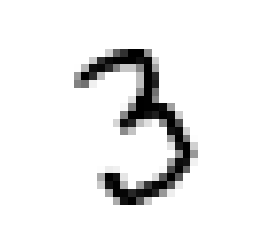

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit=x_train[30000]
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y_train[30000]

3

In [7]:
import numpy as np
shuffle_index=np.random.permutation(60000)
x_train, y_train=x_train[shuffle_index],y_train[shuffle_index]


In [8]:
y_train_3=(y_train==3)
y_test_3=(y_test==3)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(x_train, y_train_3)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds=StratifiedKFold(n_splits=3,random_state=42)

for train_index, test_index in skfolds.split(x_train,y_train_3):
    clone_clf=clone(sgd_clf)
    x_train_folds=x_train[train_index]
    y_train_folds=y_train_3[train_index]
    x_test_fold=x_train[test_index]
    y_test_fold=y_train_3[test_index]
    
    clone_clf.fit(x_train_folds,y_train_folds)
    y_pred=clone_clf.predict(x_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.9694515274236288
0.9622
0.967648382419121


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,x_train,y_train_3,cv=3,scoring="accuracy")

array([0.96945153, 0.9622    , 0.96764838])

In [13]:
from sklearn.base import BaseEstimator

class Never3Classifier(BaseEstimator):
    def fit(self,x,y=None):
        pass
    def predict(self,x):
        return np.zeros((len(x),1),dtype=bool)
never_3_clf=Never3Classifier()
cross_val_score(never_3_clf,x_train,y_train_3,cv=3,scoring="accuracy")

array([0.89655, 0.89895, 0.89795])

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgd_clf,x_train,y_train_3,cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_3,y_train_pred) #첫째 행 "3아님" 두번째 행은 "3" 

array([[52927,   942],
       [ 1072,  5059]], dtype=int64)

In [15]:
y_train_perfect_predictions=y_train_3
confusion_matrix(y_train_3,y_train_perfect_predictions)

array([[53869,     0],
       [    0,  6131]], dtype=int64)

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_3,y_train_pred)

0.8430261623062822

In [17]:
recall_score(y_train_3,y_train_pred)

0.8251508726145816

In [18]:
from sklearn.metrics import f1_score #정밀도와 재현률의 조화평균
f1_score(y_train_3,y_train_pred)

0.8339927464556545

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([179169.08929916])

In [20]:
threshold=0
y_some_digit_pred=(y_scores>threshold)

In [21]:
y_some_digit_pred

array([ True])

In [22]:
threshold=200000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

In [23]:
y_scores=cross_val_predict(sgd_clf,x_train,y_train_3,cv=3,method="decision_function")

In [24]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds=precision_recall_curve(y_train_3,y_scores)

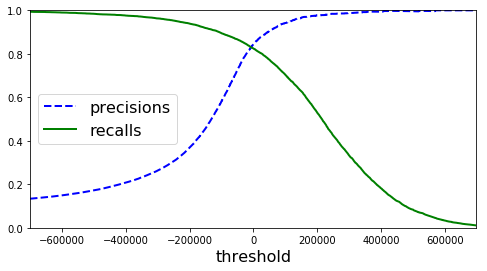

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precisions", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recalls", linewidth=2)
    plt.xlabel("threshold", fontsize=16)
    plt.legend(loc="center left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [26]:
y_train_pred_90=(y_scores>70000)

In [27]:
precision_score(y_train_3,y_train_pred_90)

0.9216552832462837

In [28]:
recall_score(y_train_3,y_train_pred_90)

0.7483281683249062

In [29]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_3,y_scores)

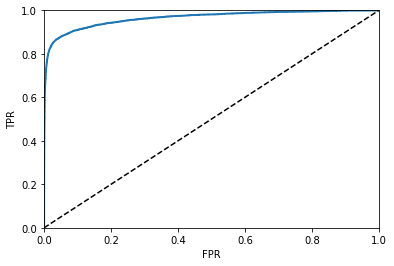

In [30]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
plot_roc_curve(fpr,tpr)
plt.show()

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_3,y_scores)

0.964726537664441

In [32]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf,x_train,y_train_3,cv=3,method="predict_proba")

In [33]:
y_probas_forest

array([[1. , 0. ],
       [0.9, 0.1],
       [1. , 0. ],
       ...,
       [0.9, 0.1],
       [1. , 0. ],
       [0.9, 0.1]])

In [34]:
y_scores_forest=y_probas_forest[:,1]
fpr_forest,tpr_forest,thresholds_forest=roc_curve(y_train_3,y_scores_forest)

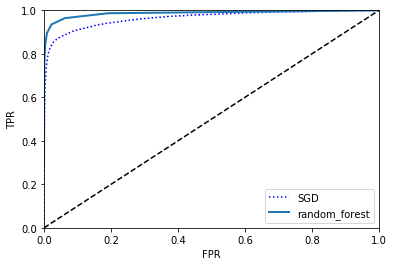

In [35]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"random_forest")
plt.legend(loc="lower right")
plt.show()

In [36]:
roc_auc_score(y_train_3,y_scores_forest)

0.9868672193005814

In [37]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train_3, cv=3)
precision_score(y_train_3,y_train_pred_forest)

0.9858664481769767

In [38]:
recall_score(y_train_3,y_train_pred_forest)

0.7850269124123308

In [39]:
sgd_clf.fit(x_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [40]:
some_digit_scores=sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-460346.99597723, -268087.67762625, -285391.77499512,
         179169.08929916, -495926.42222361, -166633.75237764,
        -569062.63051406, -297765.06907498, -114537.06713021,
        -195379.87131851]])

In [41]:
np.argmax(some_digit_scores)

3

In [42]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [43]:
sgd_clf.classes_[5]

5

In [44]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf=OneVsOneClassifier(SGDClassifier(max_iter=5,random_state=42))
ovo_clf.fit(x_train,y_train)
ovo_clf.predict([some_digit])

array([3], dtype=uint8)

In [45]:
len(ovo_clf.estimators_)

45

In [46]:
forest_clf.fit(x_train,y_train)
forest_clf.predict([some_digit])

array([3], dtype=uint8)

In [47]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [59]:
cross_val_score(sgd_clf,x_train,y_train,cv=3,scoring="accuracy")

array([0.88237353, 0.84074204, 0.86758014])

In [75]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring = 'accuracy')

MemoryError: 

TypeError: list indices must be integers or slices, not tuple